In [317]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import time
import matplotlib as mpl
start = time.time()
from progressbar import ProgressBar

In [318]:
data = pd.read_csv('FeaturesInitial_training.csv')
print (data.columns)
features_names0 = data.columns[0:18]
print (features_names0)
# Check the columns names



Index(['MolWt', 'HeavyAtomCount', 'HeavyAtomMolWt', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'NumRadicalElectrons', 'NumAliphaticCarbocycles',
       'NumAliphaticHeterocycles', 'NumAromaticCarbocycles',
       'NumAromaticHeterocycles', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles', 'Logp', 'TPSA', 'QED', 'gap'],
      dtype='object')
Index(['MolWt', 'HeavyAtomCount', 'HeavyAtomMolWt', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'NumRadicalElectrons', 'NumAliphaticCarbocycles',
       'NumAliphaticHeterocycles', 'NumAromaticCarbocycles',
       'NumAromaticHeterocycles', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles'],
      dtype='object')


In [320]:
np.mean(data['gap'])
data.shape

(3097, 22)

In [324]:
pbar = ProgressBar()
n_estimators = range(25, 100)
n_estimators= np.repeat (np.array(n_estimators), 500)
np.random.shuffle(n_estimators)

learning_rates = np.arange(0.2, 0.3, 0.001)
learning_rates= np.repeat (np.array(learning_rates), 100)
np.random.shuffle(learning_rates)

for rand in pbar((range(0, 1000))):
    X_train, X_test, y_train, y_test = train_test_split(
        data[features_names0].values,
        data['gap'].values, random_state=rand
    )

    # see train shape, overal 133K samples, 
    # all samples, train =105K , test =33K 
    # with subsampling, train= 25.1K, test = 8.4K
    #print ("Features train array shape: ",X_train.shape)
    #print ("Features test array shape: ",X_test.shape)
    #print ("Heat_capacity train shape: ",y_train.shape)
    #print ("Heat_capacity test shape:",y_test.shape)

    xgbr_final = XGBRegressor(max_depth=5, n_estimators=n_estimators[rand], 
                                        gamma=0.01, learning_rate=learning_rates[rand], 
                                        subsample=0.8,  min_child_weight=20, 
                                        n_jobs=-1, random_state=0)
    xgbr_final.fit(X_train, y_train);
    predictions = xgbr_final.predict(X_test)
    r_squared_test = r2_score(y_test, predictions)
    #print ('random: ', i)
    if r_squared_test>=0.79:
        max_random = rand
        max_n_est = n_estimators[rand]
        print ('lr: ', learning_rates[rand])
        print (rand)
        print ('r2: ', r_squared_test)
        print ('n_estimator: ', n_estimators[rand])
    #print (r_squared_test)
    train_predictions = xgbr_final.predict(X_train)
    r_squared = r2_score(y_train, train_predictions)
    #print (r_squared)
    importance = list(xgbr_final.feature_importances_)
    #print (importance)

lr:  0.26000000000000006
619
r2:  0.7948890766394915
n_estimator:  88


lr:  0.2910000000000001
662
r2:  0.7933705172993276
n_estimator:  64


lr:  0.2750000000000001
824
r2:  0.7903440171026757
n_estimator:  95


100% |########################################################################|


In [233]:
n_estimators[rand]

34

In [329]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features_names0].values,
    data['gap'].values, random_state=619
)

# see train shape, overal 133K samples, 
# all samples, train =105K , test =33K 
# with subsampling, train= 25.1K, test = 8.4K
#print ("Features train array shape: ",X_train.shape)
#print ("Features test array shape: ",X_test.shape)
#print ("Heat_capacity train shape: ",y_train.shape)
#print ("Heat_capacity test shape:",y_test.shape)

xgbr_final = XGBRegressor(max_depth=5, n_estimators=88, 
                                    gamma=0.01, learning_rate=0.25, 
                                    subsample=0.8,  min_child_weight=20, 
                                    n_jobs=-1, random_state=0)
xgbr_final.fit(X_train, y_train);
predictions = xgbr_final.predict(X_test)
r_squared_test = r2_score(y_test, predictions)
print (r_squared_test)
train_predictions = xgbr_final.predict(X_train)
r_squared = r2_score(y_train, train_predictions)
print (r_squared)
importance = list(xgbr_final.feature_importances_)
print (importance)

0.7968851595305902
0.8748969983995487
[0.014234787, 0.02762105, 0.06273236, 0.015859906, 0.013000129, 0.020622117, 0.08051448, 0.04857739, 0.03355756, 0.31227815, 0.17801392, 0.1378399, 0.011968221, 0.010915828, 0.0, 0.0060016704, 0.016828466, 0.009434097]


In [330]:
# kfolds = KFold(shuffle = True, random_state = 42)
scorer = make_scorer(mean_squared_error, greater_is_better = False)

xgb = XGBRegressor(objective = 'reg:squarederror')
param_grid = {'max_depth': range(3,10),
              'learning_rate': [0.1, 0.11, 0.13, 0.15, 0.16, 0.2, 0.25],
              'n_estimators': range(10, 500, 10),
              'min_child_weight': range(5, 50),
              'subsample': [0.7, 0.75, 0.8]}
xgb = RandomizedSearchCV(xgb, param_grid, n_iter = 500,
                         cv=3, scoring = scorer, refit = True,
                         n_jobs=-1, verbose = 1)
xgb.fit(X_train, y_train)
best_params = xgb.best_params_

xgb = XGBRegressor(objective = 'reg:squarederror',
                   n_jobs=-1)
xgb.set_params(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def mAPE(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true))

print ("r2_score: ",r2_score(y_test, y_pred))
print ("Mean of Cv_test: ",np.mean(y_test))
print ("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print ("Mean Squared Error train: ", mean_squared_error(y_train, y_pred_train))
print ("test r-square: ", r2_score ( y_test, y_pred))
print ("train r-square: ", r2_score (y_train, y_pred_train))
print ("MSE/Mean_Cv_test: ", mean_squared_error(y_test, y_pred)/np.mean(y_test))
print ("Mean absolute error: ", mean_absolute_error(y_test, y_pred))
print ("Mean_absolute_error/Mean_Cv_test: ",mean_absolute_error(y_test, y_pred)/np.mean(y_test)) 
print ("MeanAbsolutePercentage error (MAPE): ",MAPE(y_test, y_pred))
print ("MedianAbsolutePercentage error (MdAPE): ",mAPE(y_test, y_pred))
end = time.time()
print ("time: ",end-start)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
r2_score:  0.8015172082894322
Mean of Cv_test:  5.912937359403499
Mean Squared Error:  0.7463245638929282
Mean Squared Error train:  0.45813332381460553
test r-square:  0.8015172082894322
train r-square:  0.8604795596796703
MSE/Mean_Cv_test:  0.12621891938463187
Mean absolute error:  0.6848837657427586
Mean_absolute_error/Mean_Cv_test:  0.11582800968685554
MeanAbsolutePercentage error (MAPE):  0.13969941344535125
MedianAbsolutePercentage error (MdAPE):  0.09847735935245655
time:  969.1972925662994


In [331]:
best_params

{'subsample': 0.8,
 'n_estimators': 480,
 'min_child_weight': 30,
 'max_depth': 3,
 'learning_rate': 0.13}

In [379]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features_names0].values,
    data['gap'].values, random_state=619
)

# see train shape, overal 133K samples, 
# all samples, train =105K , test =33K 
# with subsampling, train= 25.1K, test = 8.4K
#print ("Features train array shape: ",X_train.shape)
#print ("Features test array shape: ",X_test.shape)
#print ("Heat_capacity train shape: ",y_train.shape)
#print ("Heat_capacity test shape:",y_test.shape)

xgbr_final = XGBRegressor(max_depth=3, n_estimators=340, 
                                    gamma=0.01, learning_rate=0.13, 
                                    subsample=0.8,  min_child_weight=31, 
                                    n_jobs=-1, random_state=1200)

#xgb.set_params(**best_params,)
xgbr_final.fit(X_train, y_train);
predictions = xgbr_final.predict(X_test)
r_squared_test = r2_score(y_test, predictions)
print (r_squared_test)
train_predictions = xgbr_final.predict(X_train)
r_squared = r2_score(y_train, train_predictions)
print (r_squared)
importance = list(xgbr_final.feature_importances_)
print (importance)

0.8001600049919841
0.8428293803762201
[0.0130149955, 0.023125052, 0.06689327, 0.014984804, 0.010518523, 0.027867272, 0.07304637, 0.042346638, 0.11241143, 0.23385699, 0.20958991, 0.09221991, 0.015684497, 0.016155899, 0.0, 0.010310753, 0.025749141, 0.012224458]


In [308]:
np.mean(data['gap'])

6.338789432108744

MAE test:  0.6848837657427586
MAE train:  0.5265250033280338


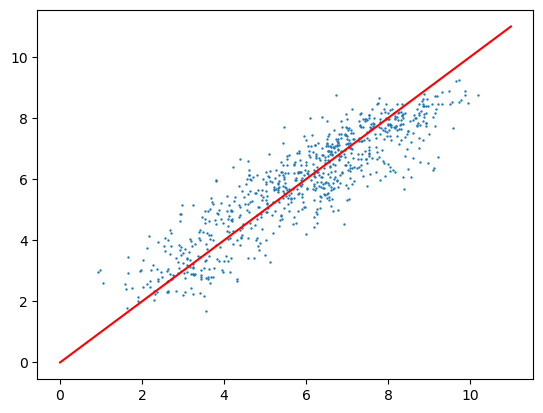

In [377]:
plt.scatter(y_test, y_pred, s=0.5)
plt.plot ([0, 11], [0, 11], color='red')
print ('MAE test: ', mean_absolute_error(y_test, y_pred))
print ('MAE train: ', mean_absolute_error(y_train, y_pred_train))

In [378]:
xgbr_final = XGBRegressor(max_depth=5, n_estimators=30, 
                                       gamma=0.01, learning_rate=0.25, 
                                       subsample=0.8,  min_child_weight=20, 
                                       n_jobs=-1, random_state=900)
xgbr_final.fit(X_train, y_train);
predictions = xgbr_final.predict(X_test)
r_squared_test = r2_score(y_test, predictions)
print (r_squared_test)
train_predictions = xgbr_final.predict(X_train)
r_squared = r2_score(y_train, train_predictions)
print (r_squared)
importance = list(xgbr_final.feature_importances_)
print (importance)

0.7602003801193231
0.8021774078970154
[0.011595979, 0.019327162, 0.041710194, 0.011778328, 0.010298244, 0.02764851, 0.07063518, 0.02891814, 0.121352024, 0.28201514, 0.2230859, 0.07464186, 0.009011136, 0.010180266, 0.0, 0.0, 0.0070846155, 0.050717335]


In [130]:
xgbr_final = XGBRegressor(max_depth=5, n_estimators=30, 
                                       gamma=0.01, learning_rate=0.25, 
                                       subsample=0.8,  min_child_weight=15, 
                                       n_jobs=-1, random_state=9)
xgbr_final.fit(X_train, y_train);
predictions = xgbr_final.predict(X_test)
r_squared_test = r2_score(y_test, predictions)
print (r_squared_test)
train_predictions = xgbr_final.predict(X_train)
r_squared = r2_score(y_train, train_predictions)
print (r_squared)
importance = list(xgbr_final.feature_importances_)
print (importance)

0.6245197070980718
0.757397888209605
[0.01638177, 0.027528757, 0.046219368, 0.020938374, 0.012632976, 0.034674324, 0.03595546, 0.04393842, 0.12671123, 0.18007661, 0.25235122, 0.09468888, 0.023730988, 0.030045444, 0.0, 0.0, 0.03853934, 0.015586832]


In [312]:
xgbr_final.feature_importances_

array([0.02031859, 0.03724879, 0.06297539, 0.0256728 , 0.02329926,
       0.03331848, 0.0421179 , 0.06487341, 0.        , 0.19933946,
       0.2678291 , 0.13166219, 0.01613342, 0.02791987, 0.        ,
       0.        , 0.01210348, 0.03518786], dtype=float32)

In [313]:
features_names0

Index(['MolWt', 'HeavyAtomCount', 'HeavyAtomMolWt', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'NumRadicalElectrons', 'NumAliphaticCarbocycles',
       'NumAliphaticHeterocycles', 'NumAromaticCarbocycles',
       'NumAromaticHeterocycles', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles'],
      dtype='object')

In [380]:
features_names = ['Mol.Wt.', 'HeavyAtomCount', 'HeavyAtomMol.Wt.', 'Num.H-Acceptors', 
             'Num.H-Donors', 'Num.Het.atoms', 'Num.Rot.Bonds', 'NumVal.Elec.',  
             'Num.Arom.Rings', 'Num.Sat.Rings', 'Num.Aliph.Rings', 'Num.Rad.Elect.', 
             'Num.Aliph.Carbocyc.', 'Num.Aliph.Het.cyc.', 'Num.Arom.Carbocyc.', 
             'Num.Arom.Het.cyc.', 'Num.Sat.Carbocyc.', 'Num.Sat.Het.cyc.']

In [381]:
importance_pd = pd.DataFrame({})
importance_pd['features'] = features_names
importance_pd['importance_values'] = np.round(importance, 4)

In [382]:
importance_pd.sort_values(by='importance_values', ascending=False)

,features,importance_values
9,Num.Sat.Rings,0.2339
10,Num.Aliph.Rings,0.2096
8,Num.Arom.Rings,0.1124
11,Num.Rad.Elect.,0.0922
6,Num.Rot.Bonds,0.0730
2,HeavyAtomMol.Wt.,0.0669
7,NumVal.Elec.,0.0423
5,Num.Het.atoms,0.0279
16,Num.Sat.Carbocyc.,0.0257
1,HeavyAtomCount,0.0231


<Axes: >

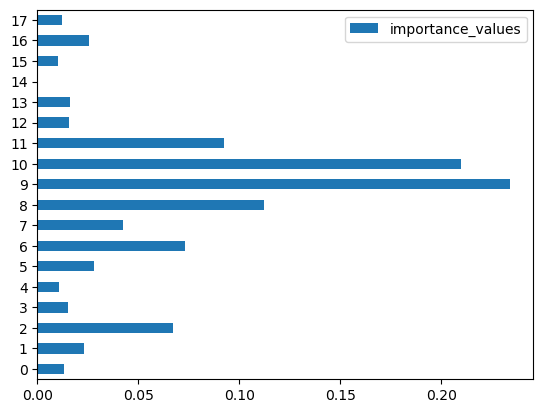

In [383]:
importance_pd.plot(kind='barh')

In [384]:
XX = pd.Series(np.round (importance, 4), index=features_names)
XX

Mol.Wt.                0.0130
HeavyAtomCount         0.0231
HeavyAtomMol.Wt.       0.0669
Num.H-Acceptors        0.0150
Num.H-Donors           0.0105
Num.Het.atoms          0.0279
Num.Rot.Bonds          0.0730
NumVal.Elec.           0.0423
Num.Arom.Rings         0.1124
Num.Sat.Rings          0.2339
Num.Aliph.Rings        0.2096
Num.Rad.Elect.         0.0922
Num.Aliph.Carbocyc.    0.0157
Num.Aliph.Het.cyc.     0.0162
Num.Arom.Carbocyc.     0.0000
Num.Arom.Het.cyc.      0.0103
Num.Sat.Carbocyc.      0.0257
Num.Sat.Het.cyc.       0.0122
dtype: float32

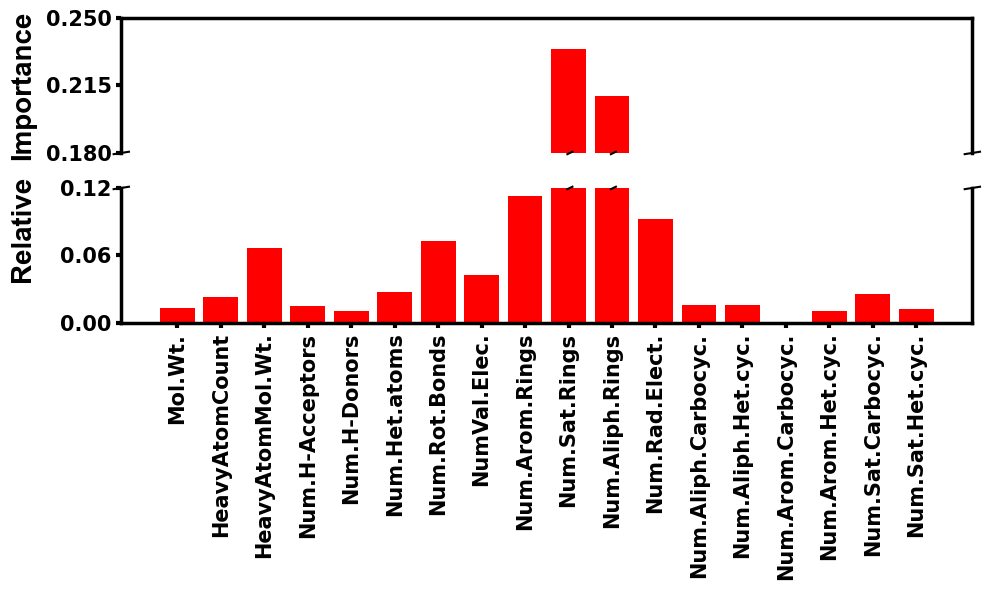

In [391]:
XX = pd.Series(np.round (importance, 4), index=features_names)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(10,6))

mpl.rcParams['axes.linewidth'] = 2.5
XX2 = np.around(XX.values, decimals=5)

ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)

plt.rcParams["figure.autolayout"] = True
bs = 0.12
ts = 0.18
ax2.set_ylim(0,bs)
ax1.set_ylim(ts, 0.25)

bars1 = ax1.bar(XX.index, XX2, color='red')
plt.sca(ax1)
plt.yticks(rotation=0, fontsize=15, fontweight='bold',)
plt.yticks(np.linspace(ts, 0.25, 3))
ax1.xaxis.set_tick_params(width=3)
ax1.yaxis.set_tick_params(width=3)
#plt.legend(["QM9"], rotation=90,fontsize=15)

bars2 = ax2.bar(XX.index, XX2, color='red')
plt.sca(ax2)
plt.xticks(rotation=90, fontweight='bold', fontsize=15)
plt.yticks(rotation=0, fontweight='bold', fontsize=15)

plt.yticks(np.linspace(0, bs, 3))
ax2.xaxis.set_tick_params(width=3)
ax2.yaxis.set_tick_params(width=3)
ax1.set_ylabel('Importance', fontweight='bold', fontsize=20, fontname='Arial')
ax2.set_ylabel('Relative', fontweight='bold', fontsize=20, fontname='Arial')
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax2.yaxis.set_label_coords(-0.1, 0.7)
"""
for tick in ax2.get_xticklabels():
    tick.set_rotation(-45, fontsize=15)
"""
d = .009
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)


for b1, b2 in zip(bars1, bars2):
    posx = b2.get_x() + b2.get_width()/2.
    if b2.get_height() > bs:
        ax2.plot((posx-3*d, posx+10*d), (1 - d, 1 + d), color='k', clip_on=False,
                 transform=ax2.get_xaxis_transform())
    if b1.get_height() > ts:
        ax1.plot((posx-3*d, posx+10*d), (- d, + d), color='k', clip_on=False,
                 transform=ax1.get_xaxis_transform())

plt.tight_layout()
plt.savefig('last_features.jpeg', bbox_inches='tight', dpi=500)